# 1.30h: Lattice Quantization Analysis

**Purpose:** Verify that dead token motion is actually quantized to the bfloat16 lattice.

## Questions

1. **Data quality:** Are lattice displacements close to integers? (If so, motion is quantized)
2. **Hop distribution:** What integer hop sizes do we see? (0, 1, 2, ...)
3. **L1 statistics:** How does total coordinate change evolve?
4. **Fractionality:** Are L1 norms close to integers? (Measure of axis-aligned motion)
5. **Sanity check:** Does motion actually stop at t=3292?

## Approach

Exploratory—no regime assumptions. Just looking at what the data shows.

## Parameters

In [1]:
# Data path
DATA_PATH = "../tensors/Thimble/thimble_6.h5"

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

# Known freeze point
PERMANENT_FREEZE_START = 3292

print("✓ Parameters set")

✓ Parameters set


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Load Data (Keep in bfloat16!)

In [3]:
print(f"Loading dead token trajectories from {DATA_PATH}...\n")

with h5py.File(DATA_PATH, 'r') as f:
    # Load metadata
    n_steps = f.attrs['num_steps']
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    n_dead = dead_mask.sum().item()
    
    # Load dead token trajectories as bfloat16
    print(f"Loading W[:, dead_mask, :] ... ({n_steps+1} × {n_dead} × 64)")
    W_dead = torch.from_numpy(f['W'][:, dead_mask, :]).to(torch.bfloat16)

print(f"\n✓ Data loaded: {tuple(W_dead.shape)}")
print(f"Dtype: {W_dead.dtype}")
print(f"Dead tokens: {n_dead}")

Loading dead token trajectories from ../tensors/Thimble/thimble_6.h5...

Loading W[:, dead_mask, :] ... (6001 × 3699 × 64)

✓ Data loaded: (6001, 3699, 64)
Dtype: torch.bfloat16
Dead tokens: 3699


## Define ULP Computation

In [4]:
def compute_ulp(x):
    """
    Compute the ULP (Unit in Last Place) for each element in x.
    x should be in the dtype you want to compute ULP for (bfloat16 here).
    """
    ulp_pos = torch.nextafter(x, x + torch.ones_like(x)) - x
    ulp_neg = x - torch.nextafter(x, x - torch.ones_like(x))
    ulp = torch.where(x >= 0, ulp_pos, ulp_neg)
    return ulp.abs()

print("✓ ULP function defined")

✓ ULP function defined


## Compute Lattice Displacements

In [5]:
print("Computing lattice-space displacements...\n")

# ULP at starting positions (bfloat16)
U_start = compute_ulp(W_dead[:-1])  # (6000, 3699, 64)

# Displacement in physical space (bfloat16)
dW = W_dead[1:] - W_dead[:-1]  # (6000, 3699, 64)

# Transform to lattice space
dW_lattice_bf16 = dW / (U_start + 1e-30)  # bfloat16

# Convert to float32 for analysis
dW_lattice = dW_lattice_bf16.float()

print(f"Lattice displacements: {tuple(dW_lattice.shape)}")
print(f"\n✓ Lattice transformation complete")

Computing lattice-space displacements...

Lattice displacements: (6000, 3699, 64)

✓ Lattice transformation complete


## Compute L1 Norms (Total Coordinate Change)

In [6]:
print("Computing L1 norms (sum of absolute coordinate changes)...\n")

# L1 norm per token: sum of absolute changes across 64 dimensions
dW_lattice_L1 = dW_lattice.abs().sum(dim=2)  # (6000, 3699)

print(f"L1 norms: {tuple(dW_lattice_L1.shape)}")
print(f"\n✓ L1 norms computed")

Computing L1 norms (sum of absolute coordinate changes)...

L1 norms: (6000, 3699)

✓ L1 norms computed


## 1. Data Quality Check: Distance to Nearest Integer

In [13]:
print("Computing distance to nearest integer for each coordinate...\n")

# Distance to nearest integer: |x - round(x)|
dist_to_int = (dW_lattice - dW_lattice.round()).abs()  # (6000, 3699, 64)

# Flatten to all coordinates
dist_flat = dist_to_int.flatten().numpy()

print("=" * 80)
print("DATA QUALITY REPORT: INTEGER-NESS OF LATTICE COORDINATES")
print("=" * 80 + "\n")

print(f"Total coordinates analyzed: {len(dist_flat):,}\n")

print("Distance to nearest integer:")
print("-" * 40)
print(f"  Mean:       {dist_flat.mean():.6f}")
print(f"  Median:     {np.median(dist_flat):.6f}")
print(f"  Std dev:    {dist_flat.std():.6f}")
print(f"  Min:        {dist_flat.min():.6f}")
print(f"  Max:        {dist_flat.max():.6f}")
print(f"  10th %ile:  {np.percentile(dist_flat, 10):.6f}")
print(f"  90th %ile:  {np.percentile(dist_flat, 90):.6f}")

print("\nFraction of coordinates by closeness:")
print("-" * 40)
print(f"  Exactly 0:           {(dist_flat == 0).mean():.2%}")
print(f"  Within 0.01:         {(dist_flat < 0.01).mean():.2%}")
print(f"  Within 0.05:         {(dist_flat < 0.05).mean():.2%}")
print(f"  Within 0.1:          {(dist_flat < 0.1).mean():.2%}")
print(f"  Within 0.25:         {(dist_flat < 0.25).mean():.2%}")
print(f"  > 0.4 (far from int): {(dist_flat > 0.4).mean():.2%}")

print("\n" + "=" * 80)
print("Interpretation:")
print("  High fraction near 0 → quantized (lattice hops)")
print("  Uniform distribution 0-0.5 → continuous motion")
print("=" * 80)

Computing distance to nearest integer for each coordinate...

DATA QUALITY REPORT: INTEGER-NESS OF LATTICE COORDINATES

Total coordinates analyzed: 1,420,416,000

Distance to nearest integer:
----------------------------------------
  Mean:       0.000076
  Median:     0.000000
  Std dev:    0.006167
  Min:        0.000000
  Max:        0.500000
  10th %ile:  0.000000
  90th %ile:  0.000000

Fraction of coordinates by closeness:
----------------------------------------
  Exactly 0:           99.98%
  Within 0.01:         99.98%
  Within 0.05:         99.98%
  Within 0.1:          99.98%
  Within 0.25:         99.98%
  > 0.4 (far from int): 0.02%

Interpretation:
  High fraction near 0 → quantized (lattice hops)
  Uniform distribution 0-0.5 → continuous motion


## 2. Hop Size Distribution (Integer Bar Chart)

Computing hop size distribution...



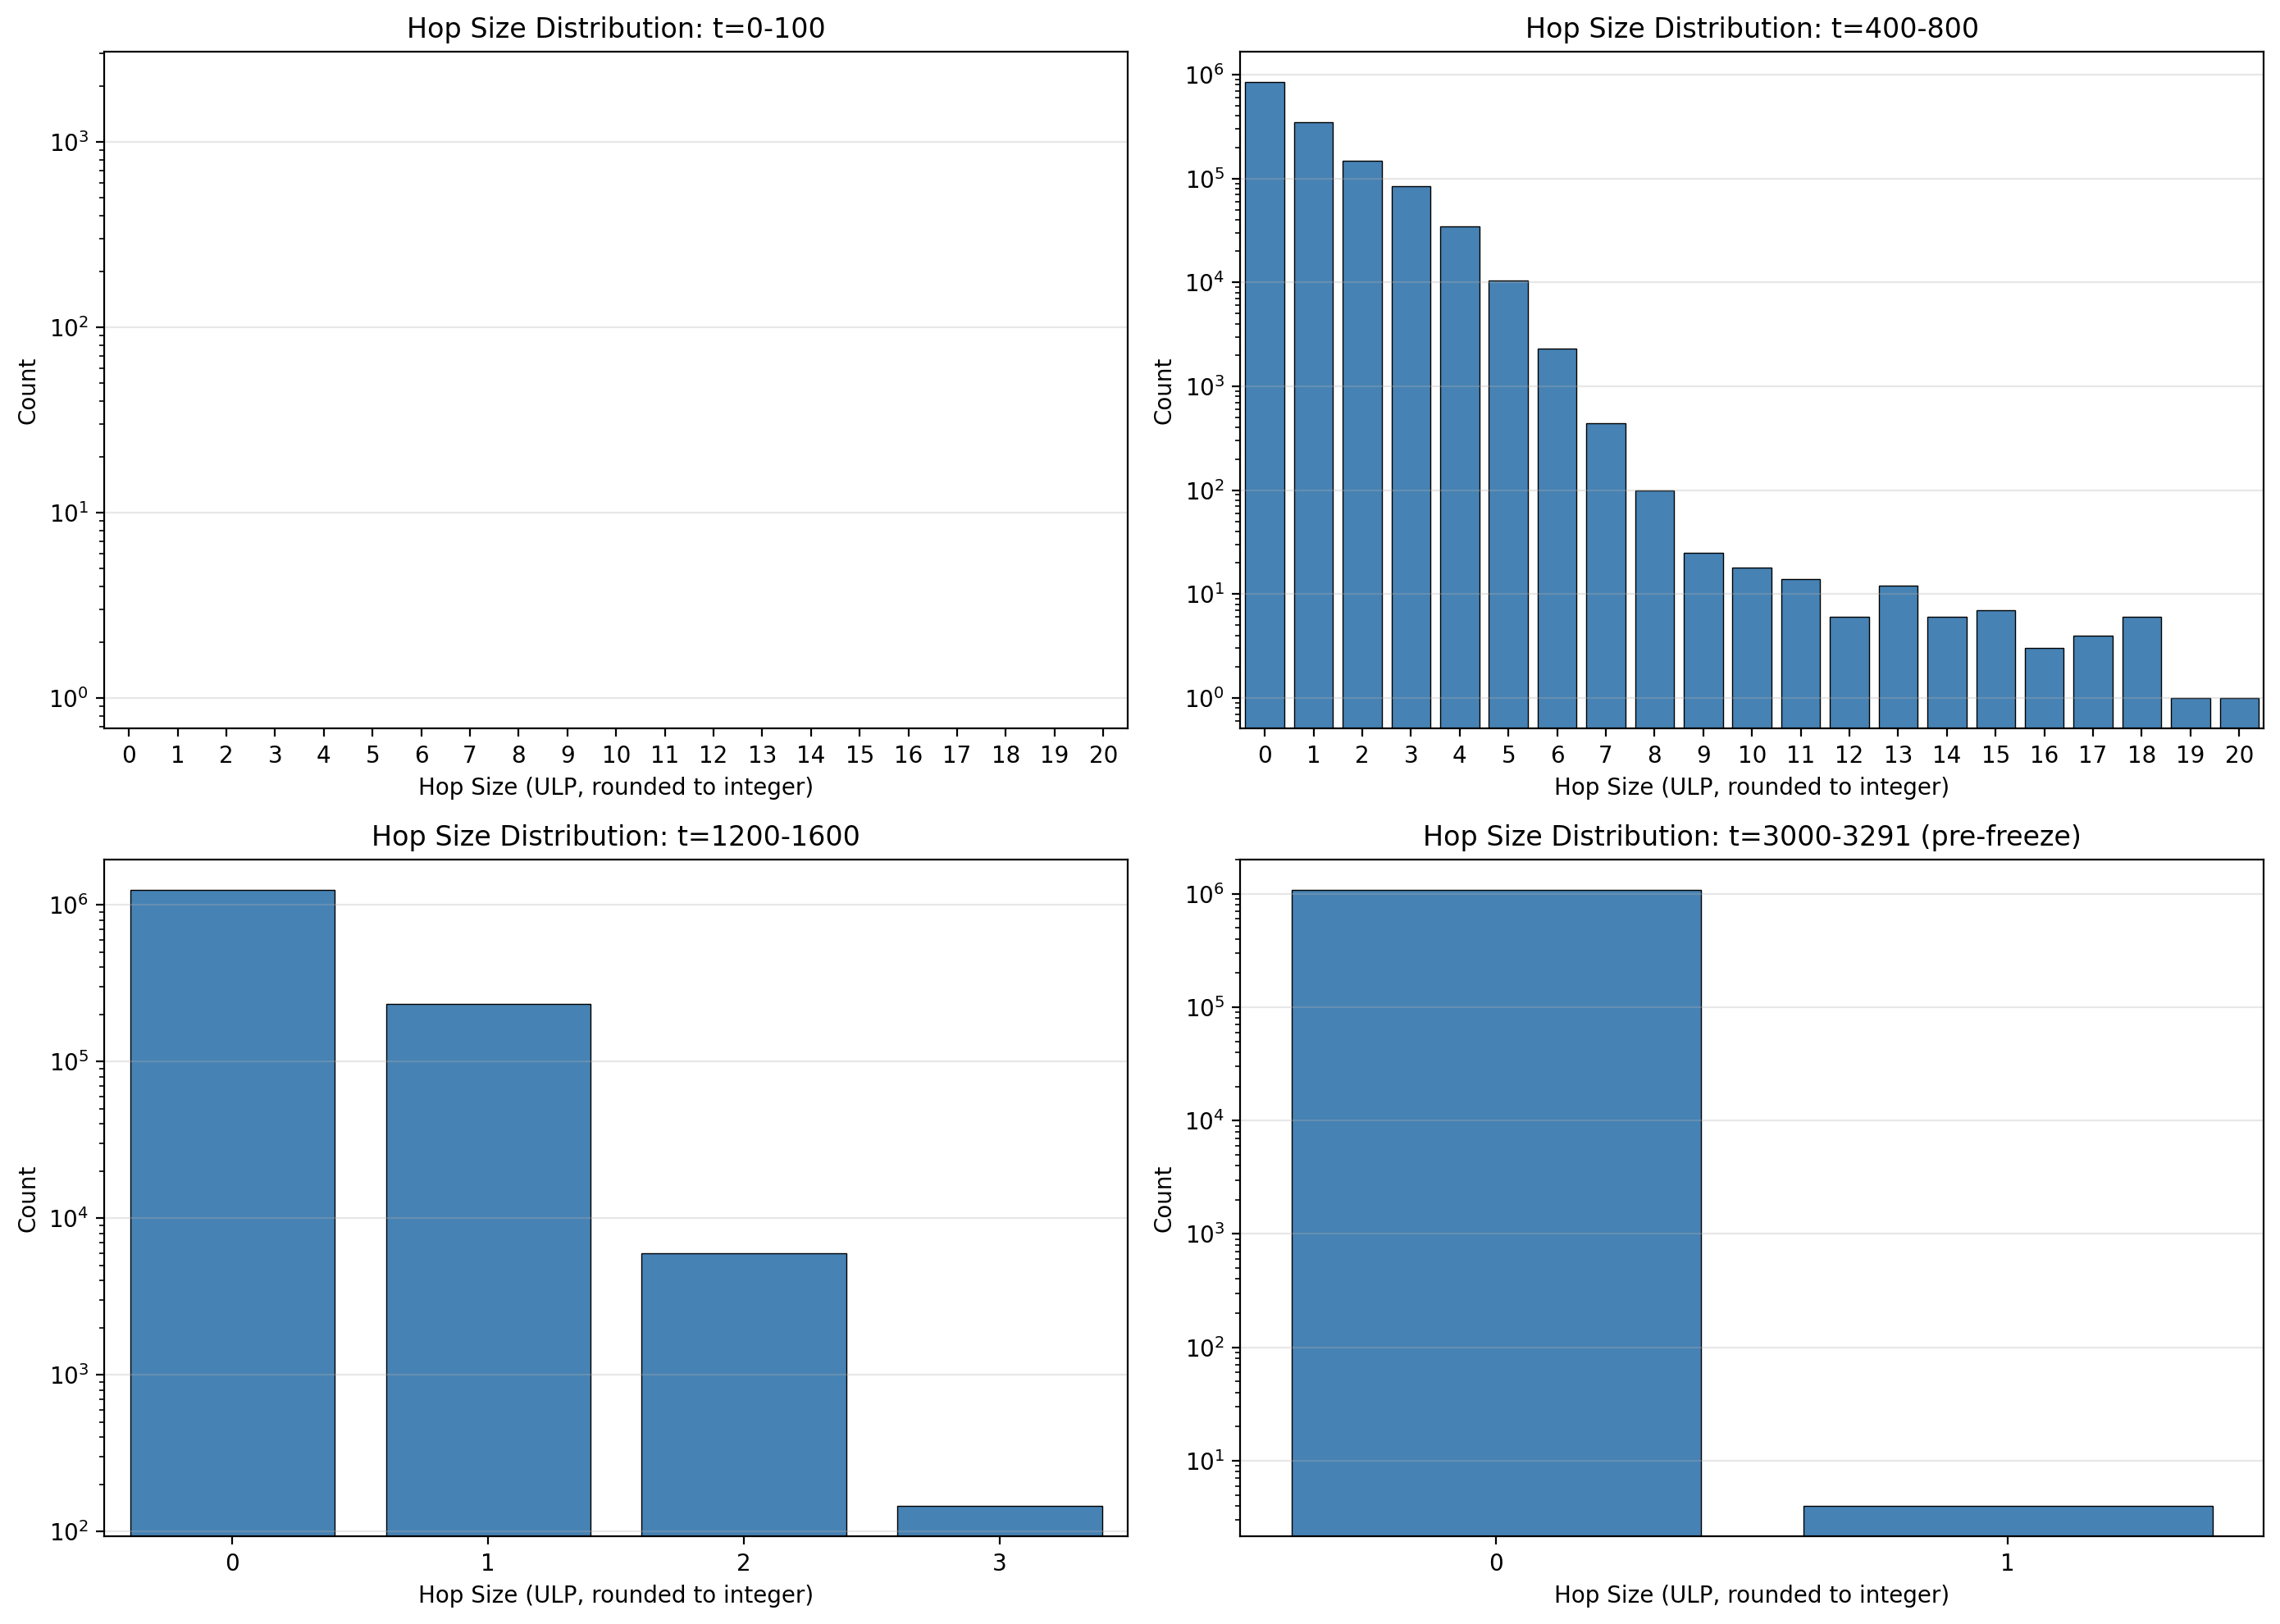


Interpretation:
  Early: Broad distribution (continuous motion)
  Late: Peaked at 0, 1, 2, ... (quantized hops)


In [14]:
print("Computing hop size distribution...\n")

# Round L1 norms to nearest integer
L1_rounded = dW_lattice_L1.round()  # (6000, 3699)

# Define time windows for comparison
windows = [
    (0, 100, "t=0-100"),
    (400, 800, "t=400-800"),
    (1200, 1600, "t=1200-1600"),
    (3000, 3292, "t=3000-3291 (pre-freeze)"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=DPI)
axes = axes.flatten()

for ax, (t_start, t_end, label) in zip(axes, windows):
    # Get L1 data for this window
    data = L1_rounded[t_start:t_end].flatten().numpy()
    
    # Count frequency of each integer hop size
    unique, counts = np.unique(data, return_counts=True)
    
    # Bar chart
    ax.bar(unique, counts, width=0.8, color='steelblue', edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Hop Size (ULP, rounded to integer)')
    ax.set_ylabel('Count')
    ax.set_title(f'Hop Size Distribution: {label}')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Set reasonable x-axis limits and force integer ticks
    if len(unique) > 0:
        max_hop = min(int(unique.max()), 20)  # Cap at 20 for readability
        ax.set_xlim([-0.5, max_hop + 0.5])
        ax.set_xticks(range(0, max_hop + 1))

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Early: Broad distribution (continuous motion)")
print("  Late: Peaked at 0, 1, 2, ... (quantized hops)")

## 3. L1 Statistics Over Time

Computing L1 statistics over time...



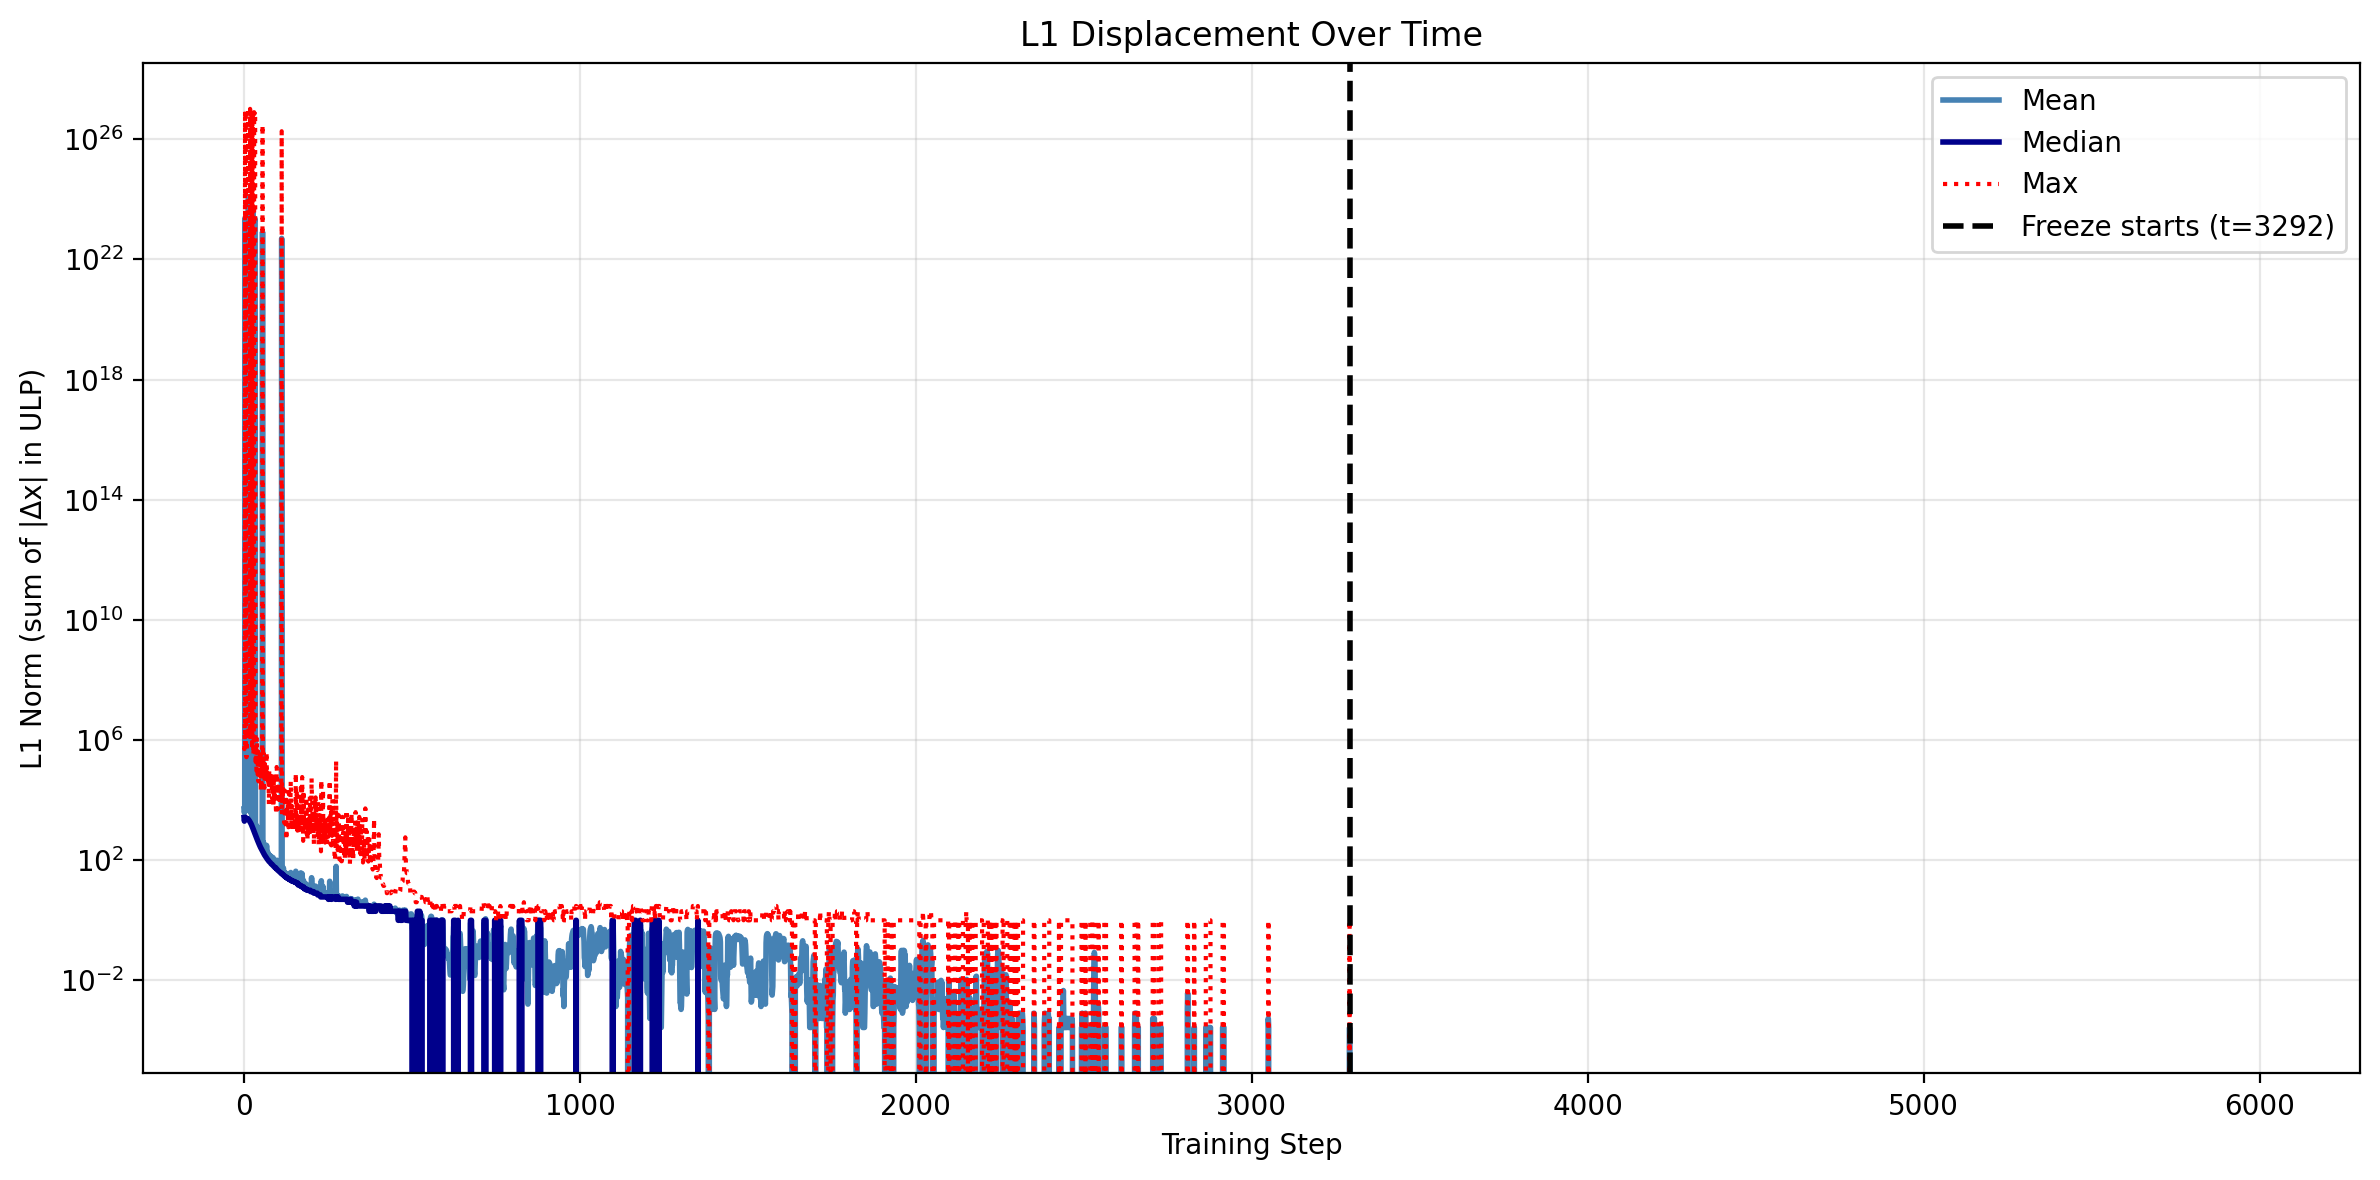


Max L1 at t=3292: 0.000000
Max L1 after freeze (t>3292): 0.000000


In [9]:
print("Computing L1 statistics over time...\n")

# Per-timestep statistics
mean_L1 = dW_lattice_L1.mean(dim=1).numpy()  # (6000,)
median_L1 = dW_lattice_L1.median(dim=1)[0].numpy()  # (6000,)
max_L1 = dW_lattice_L1.max(dim=1)[0].numpy()  # (6000,)

fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(mean_L1, linewidth=2, color='steelblue', label='Mean')
ax.plot(median_L1, linewidth=2, color='darkblue', label='Median')
ax.plot(max_L1, linewidth=1.5, linestyle=':', color='red', label='Max')

ax.axvline(PERMANENT_FREEZE_START, color='black', linestyle='--', linewidth=2, 
           label=f'Freeze starts (t={PERMANENT_FREEZE_START})')

ax.set_xlabel('Training Step')
ax.set_ylabel('L1 Norm (sum of |Δx| in ULP)')
ax.set_title('L1 Displacement Over Time')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nMax L1 at t={PERMANENT_FREEZE_START}: {max_L1[PERMANENT_FREEZE_START]:.6f}")
print(f"Max L1 after freeze (t>{PERMANENT_FREEZE_START}): {max_L1[PERMANENT_FREEZE_START:].max():.6f}")

## 4. Fractionality: How Close is L1 to an Integer?

Computing fractionality (distance of L1 to nearest integer)...



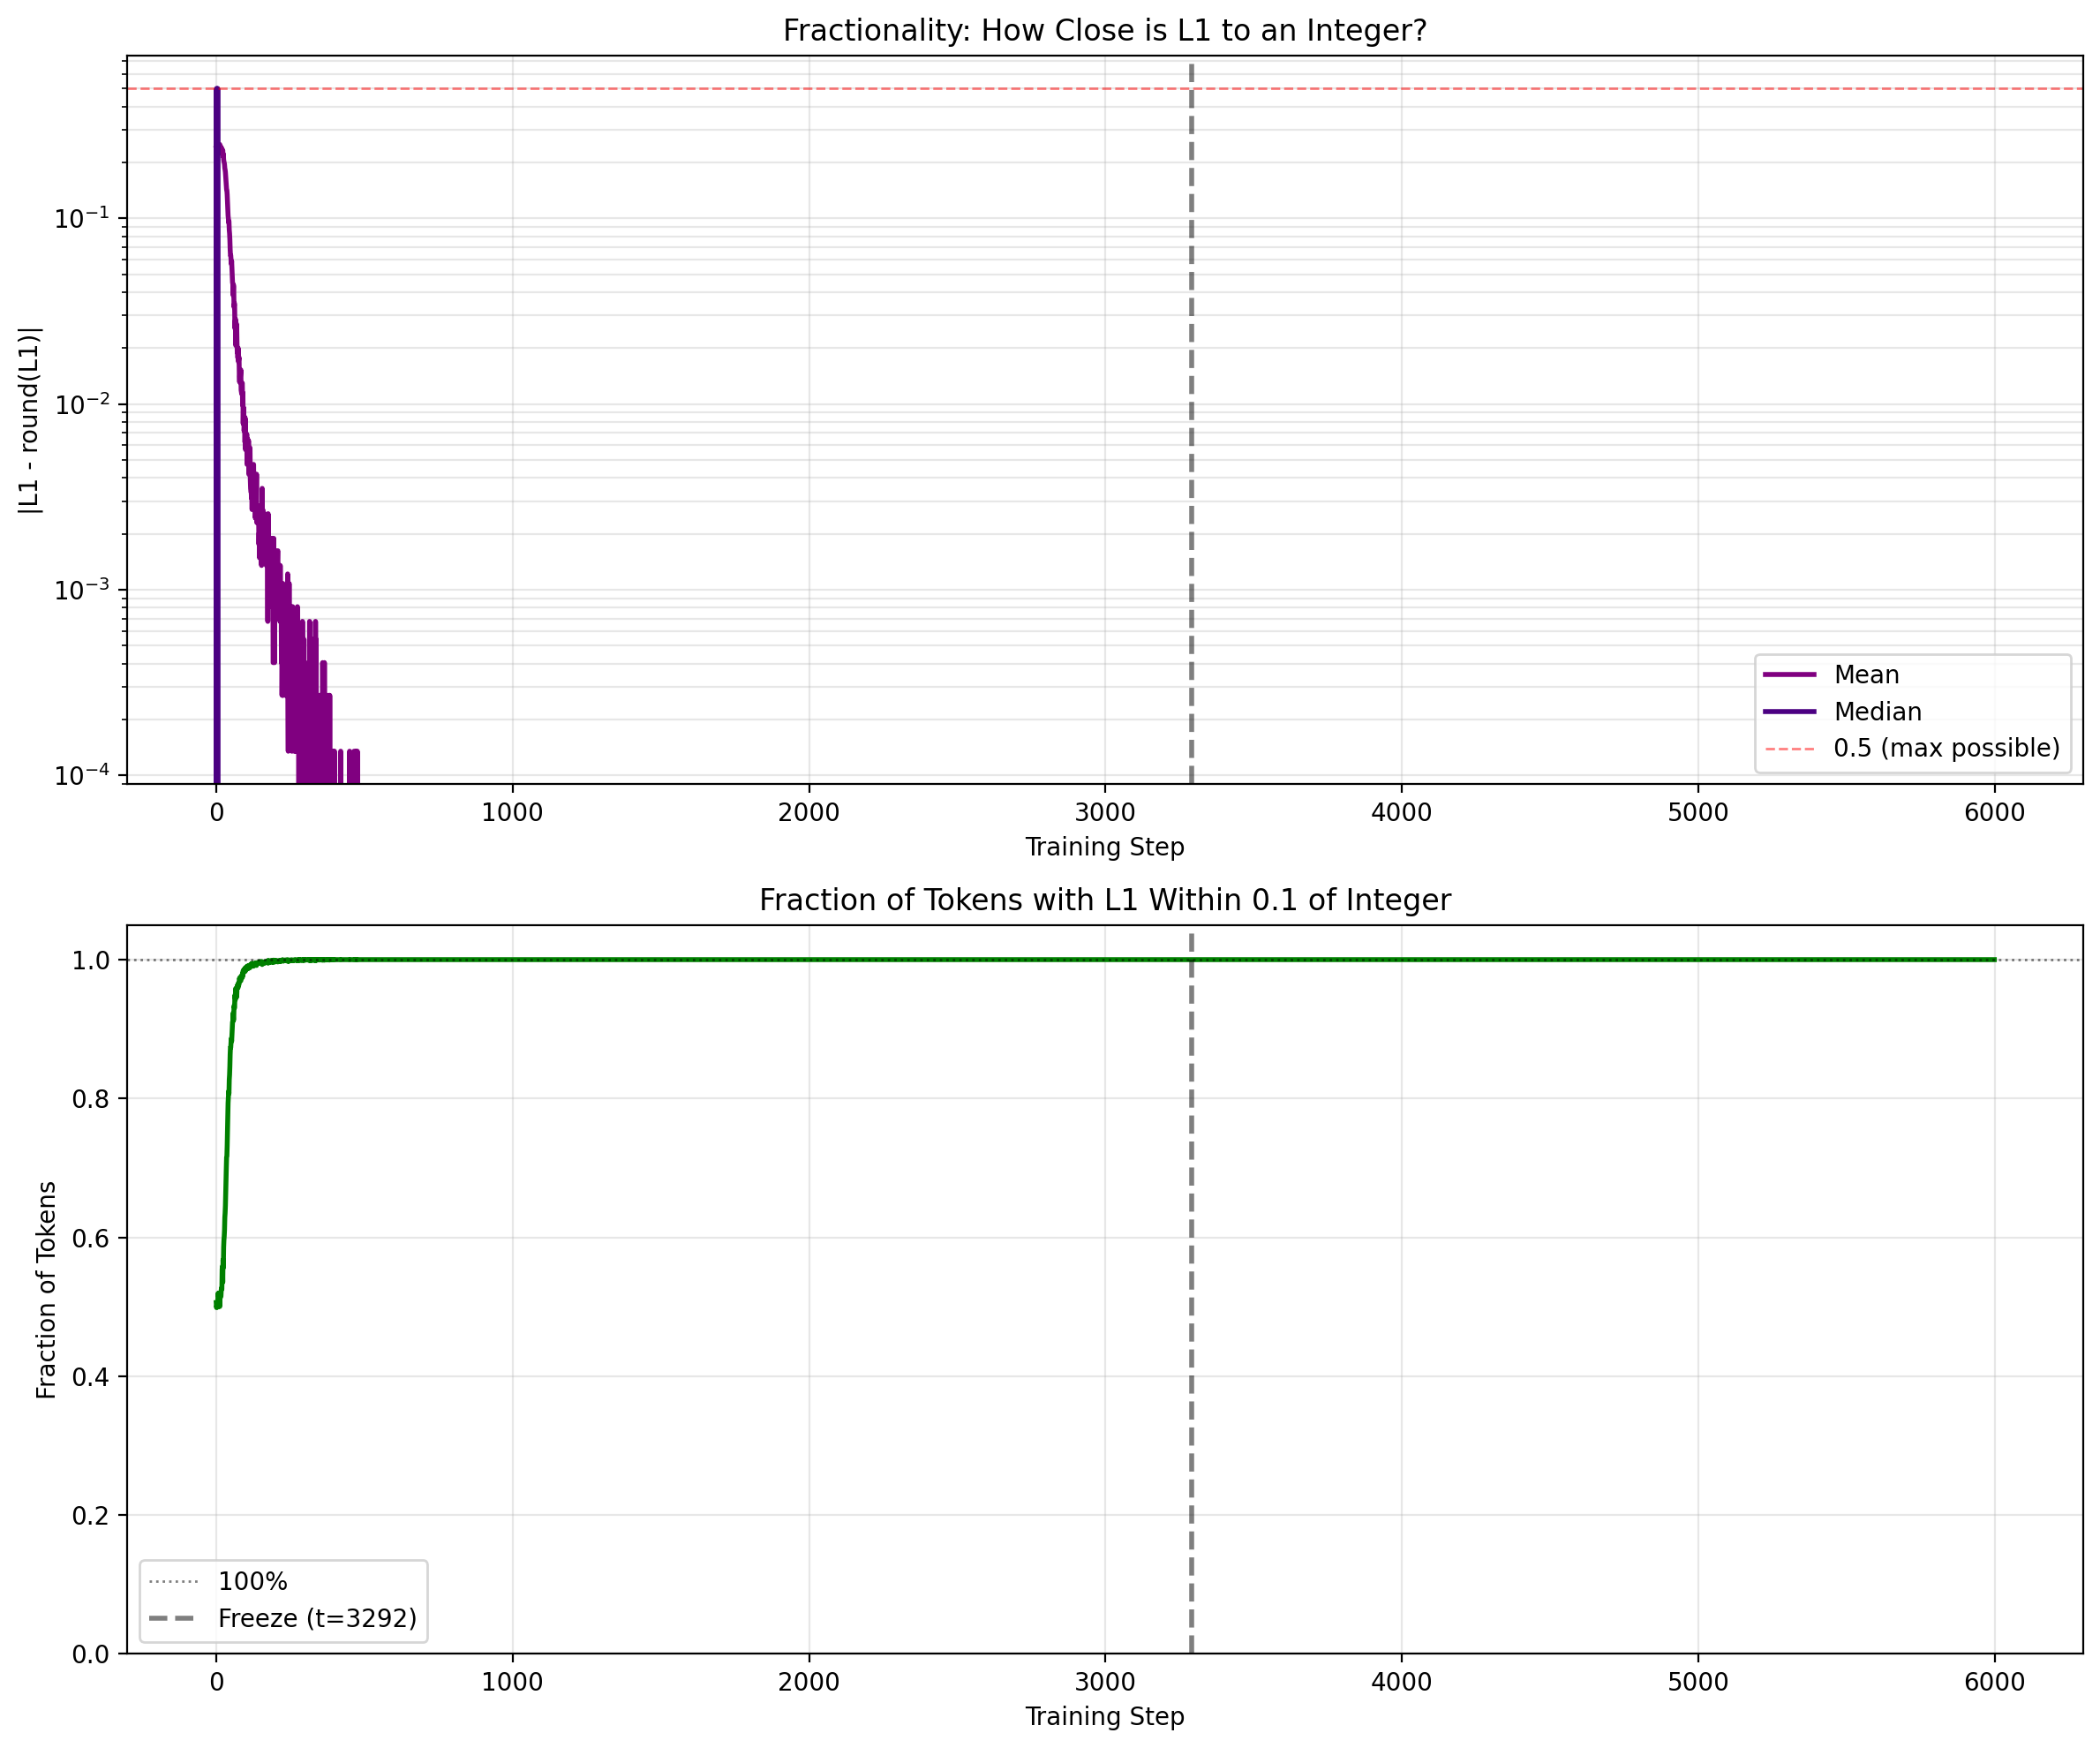


Interpretation:
  Low fractionality → axis-aligned lattice hops
  High fractionality → diagonal or continuous motion

Final timestep (t=5999):
  Mean fractionality: 0.000000
  Fraction within 0.1: 100.0%


In [10]:
print("Computing fractionality (distance of L1 to nearest integer)...\n")

# Distance of L1 norm to nearest integer
L1_fractional = (dW_lattice_L1 - dW_lattice_L1.round()).abs()  # (6000, 3699)

# Statistics per timestep
mean_frac = L1_fractional.mean(dim=1).numpy()  # (6000,)
median_frac = L1_fractional.median(dim=1)[0].numpy()  # (6000,)

# Fraction of tokens with L1 within 0.1 of an integer
close_to_int_L1 = (L1_fractional < 0.1).float().mean(dim=1).numpy()  # (6000,)

fig, axes = plt.subplots(2, 1, figsize=(12, 10), dpi=DPI)

# Plot 1: Distance to integer
ax = axes[0]
ax.plot(mean_frac, linewidth=2, color='purple', label='Mean')
ax.plot(median_frac, linewidth=2, color='indigo', label='Median')
ax.axhline(0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='0.5 (max possible)')
ax.axvline(PERMANENT_FREEZE_START, color='black', linestyle='--', linewidth=2, alpha=0.5)

ax.set_xlabel('Training Step')
ax.set_ylabel('|L1 - round(L1)|')
ax.set_title('Fractionality: How Close is L1 to an Integer?')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

# Plot 2: Fraction within 0.1 of integer
ax = axes[1]
ax.plot(close_to_int_L1, linewidth=2, color='green')
ax.axhline(1.0, color='black', linestyle=':', linewidth=1, alpha=0.5, label='100%')
ax.axvline(PERMANENT_FREEZE_START, color='black', linestyle='--', linewidth=2, alpha=0.5,
           label=f'Freeze (t={PERMANENT_FREEZE_START})')

ax.set_xlabel('Training Step')
ax.set_ylabel('Fraction of Tokens')
ax.set_title('Fraction of Tokens with L1 Within 0.1 of Integer')
ax.set_ylim([0, 1.05])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Low fractionality → axis-aligned lattice hops")
print("  High fractionality → diagonal or continuous motion")
print(f"\nFinal timestep (t=5999):")
print(f"  Mean fractionality: {mean_frac[-1]:.6f}")
print(f"  Fraction within 0.1: {close_to_int_L1[-1]:.1%}")

## 5. Sanity Check: Verify Freeze at t=3292

In [11]:
print("\n" + "="*80)
print("SANITY CHECK: PERMANENT FREEZE")
print("="*80 + "\n")

# Check that all motion stops at t=3292
max_after_freeze = dW_lattice_L1[PERMANENT_FREEZE_START:].max().item()
mean_after_freeze = dW_lattice_L1[PERMANENT_FREEZE_START:].mean().item()

print(f"After t={PERMANENT_FREEZE_START}:")
print(f"  Max L1 displacement: {max_after_freeze:.6e}")
print(f"  Mean L1 displacement: {mean_after_freeze:.6e}")

if max_after_freeze == 0:
    print("\n✓ PASS: All tokens frozen (max displacement = 0 exactly)")
else:
    print(f"\n✗ FAIL: Motion detected after freeze! Max = {max_after_freeze}")
    # Find which timestep has motion
    moving_steps = (dW_lattice_L1[PERMANENT_FREEZE_START:].max(dim=1)[0] > 0).nonzero()
    if len(moving_steps) > 0:
        first_motion = moving_steps[0].item() + PERMANENT_FREEZE_START
        print(f"  First motion after freeze: t={first_motion}")

print("\n" + "="*80)


SANITY CHECK: PERMANENT FREEZE

After t=3292:
  Max L1 displacement: 0.000000e+00
  Mean L1 displacement: 0.000000e+00

✓ PASS: All tokens frozen (max displacement = 0 exactly)



## Summary

In [12]:
print("\n" + "="*80)
print("LATTICE QUANTIZATION ANALYSIS SUMMARY")
print("="*80 + "\n")

print("KEY FINDINGS:\n")

# Find crossover point where >50% of coordinates are within 0.1 of integer
quantized_fraction = (dist_to_int < 0.1).float().mean(dim=(1, 2)).numpy()
crossover = np.where(quantized_fraction > 0.5)[0]
if len(crossover) > 0:
    t_quantized = crossover[0]
    print(f"1. Quantization onset: t≈{t_quantized} (>50% coords within 0.1 of integer)")
else:
    print(f"1. Quantization onset: Never reached 50% threshold")

# Most common hop size in late training
late_hops = L1_rounded[1200:3292].flatten()
late_hops_nonzero = late_hops[late_hops > 0]
if len(late_hops_nonzero) > 0:
    mode_hop = late_hops_nonzero.mode()[0].item()
    print(f"2. Most common hop size (t=1200-3291): {mode_hop:.0f} ULP")

# Final statistics
print(f"3. Permanent freeze: t={PERMANENT_FREEZE_START} (verified: max motion = {max_after_freeze:.0e})")

print("\n" + "="*80)
print("✓ Lattice quantization analysis complete.")
print("="*80)


LATTICE QUANTIZATION ANALYSIS SUMMARY

KEY FINDINGS:

1. Quantization onset: t≈0 (>50% coords within 0.1 of integer)
2. Most common hop size (t=1200-3291): 1 ULP
3. Permanent freeze: t=3292 (verified: max motion = 0e+00)

✓ Lattice quantization analysis complete.
